## Mushroom Pokédex Project
Author: Alexander Mars
14/04/2020

The goal of this project is to build a CNN capable of predicting a mushroom's species from its photo. 
I have built simpler iterations based on images scraped from google images. 
For this iteration, I have kindly been given access to the mushroomobserver.org database (thank you Jason!), which contains over 1 million images of various fungi. Note that the database does not consist solely of mushrooms but may contain slimes, molds, and microscopic features of fungi. 

This database has been built from user-uploaded images that are generally collected whilst foraging. A user who uploads a photo or record of a mushroom creates an 'observation' on the mushroomobserver. At the time of upload a user can postulate what species they think the mushroom is. Over time each observation will have an associated vote of confidence (floating point number from 0-3) which is created by other users voting on what species they think the given observation is. 

So my goal here is to what level of accuracy can be achieved with a CNN given a large number of high quality images. Obviously mushroom classification is still a fine-grained problem, so this will be interesting!

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import * # for ease of use
from fastai.metrics import error_rate
import os, math, numpy, pandas as pd


### Cleaning Up the Data

In this iteration I'm going to try with observations of confidence 2.5 or higher:


In [30]:
datapath = Path('/notebooks/storage/mushroom-obs-data/')
datapath

PosixPath('/notebooks/storage/mushroom-obs-data')

The below CSVs were generated using the mush-obs-filtering notebook:

In [31]:
species = pd.read_csv(datapath/'species_conf2.5_taxons1-4.csv')
species_obs = pd.read_csv(datapath/'obs_conf2.5_taxons1-4.csv')
images = pd.read_csv(datapath/'images_observations.csv')

### Most Commonly Observed Mushrooms

Now getting the top 100 frequently observed obs is trivial using pandas

In [32]:
top_100_taxons = species_obs['taxon_id'].value_counts()[:100].index.tolist()

In [33]:
# Most observed
len(species_obs[species_obs.taxon_id=='s8935.0'].index)

525

In [37]:
species[species.synonym_id==8935.0].iloc[0]['text_name']

'Amanita muscaria'

No surprises there, the most commonly observed mushroom on mushroom observer (species level and below) is Amanita muscaria! 

In [39]:
# 100th most observed
len(species_obs[species_obs.taxon_id=='s3882.0'].index)

110

Now I'm going to see how many images are associated with each taxon_id

Each image is associated with an observation, and we can see that multiple images may be linked to an observation

In [41]:
species_obs[species_obs.taxon_id=='s515.0']
taxon_images = {}
images_per_taxon = {}
for t_id in top_100_taxons:
    t_obs = list(species_obs.loc[species_obs.taxon_id==t_id,'id'])
    taxon_images[t_id] = list(images.loc[images.observation_id.isin(t_obs),'image_id'])
    images_per_taxon[t_id] = len(images.loc[images.observation_id.isin(t_obs)].index)

In [42]:
images_per_taxon

{'s8935.0': 1463,
 's4152.0': 1099,
 's2852.0': 769,
 's8882.0': 845,
 's2818.0': 772,
 's2669.0': 767,
 's2883.0': 661,
 's7059.0': 653,
 's8924.0': 621,
 's253.0': 465,
 's4157.0': 1075,
 's3614.0': 571,
 's8908.0': 500,
 's7118.0': 1012,
 's8869.0': 583,
 's2735.0': 759,
 's6107.0': 468,
 's6024.0': 477,
 's7649.0': 467,
 's6080.0': 474,
 's5848.0': 480,
 's2523.0': 558,
 's537.0': 382,
 'n44785': 486,
 's2663.0': 477,
 's8982.0': 443,
 'n100': 388,
 's3868.0': 372,
 's508.0': 450,
 's7558.0': 390,
 's2853.0': 336,
 's2814.0': 430,
 's4455.0': 358,
 's57.0': 536,
 's4073.0': 406,
 's6768.0': 376,
 's2592.0': 362,
 's174.0': 314,
 's2591.0': 312,
 's6913.0': 770,
 's2854.0': 402,
 's5053.0': 336,
 's2681.0': 361,
 's2650.0': 422,
 's4176.0': 403,
 's8986.0': 605,
 'n271': 440,
 's5575.0': 271,
 's2994.0': 447,
 's496.0': 266,
 's2876.0': 329,
 's6563.0': 401,
 'n139': 372,
 's2536.0': 376,
 's8870.0': 355,
 's3684.0': 364,
 'n53': 353,
 's6222.0': 281,
 's641.0': 368,
 's8905.0': 379

In [43]:
sum(images_per_taxon.values())

42198

Ok so we have 42, 198 images of mushrooms across the top 100 most commonly observed taxons.

### Downloading Images

#### Create an image directory

In [7]:
mushroom_images = Path(datapath/'mushroom-images-conf')

In [59]:
os.mkdir(mushroom_images)

#### Creating classes

Now I'm to create classes that will be used to train the model, these classes will serve as folder and file names for their respective images too.

In [48]:
# Synonym_id Rank -> String
# Get all the class names for the most commonly observed taxons
def get_class_name(tax_id, r):
    
    def get_class_subf(condition, id_val, r):
        return species[(species[condition]==float(id_val)) & (species['rank']==r)]
    
    if tax_id[0] == 's':
        c = get_class_subf('synonym_id', tax_id[1:], r)
        if not c.empty:
            return c.iloc[0]['text_name'].replace(' ', '-')
        else:
            '-'.join(get_class_name(tax_id,r-1).split()[:2])
    else:
        c = get_class_subf('id', tax_id[1:], r)
        if not c.empty:
            return c.iloc[0]['text_name'].replace(' ', '-')
        else:
            '-'.join(get_class_name(tax_id,r-1).split()[:2])

classes = []
for t_id in top_100_taxons:
    c = get_class_name(t_id, 4)
    classes.append(c)

In [49]:
# Sanity check that there are no duplicates in this list
# there should not be if the assimilate taxon_ids algorithm worked properly
len(classes) == len(set(classes))

True

In [50]:
classes

['Amanita-muscaria',
 'Trametes-versicolor',
 'Schizophyllum-commune',
 'Lepista-nuda',
 'Galerina-autumnalis',
 'Coprinus-comatus',
 'Phaeolus-schweinitzii',
 'Polyporus-squamosus',
 'Pleurotus-ostreatus',
 'Lycoperdon-perlatum',
 'Mixed-collection',
 'Lenzites-betulina',
 'Hypholoma-fasciculare',
 'Psilocybe-cyanescens',
 'Boletus-edulis',
 'Amanita-phalloides',
 'Mycena-leaiana',
 'Mycena-haematopus',
 'Hypomyces-lactifluorum',
 'Ganoderma-applanatum',
 'Laetiporus-sulphureus',
 'Trichaptum-biforme',
 'Lycoperdon-pyriforme',
 'Tricholoma-murrillianum',
 'Panellus-stipticus',
 'Leratiomyces-ceres',
 'Pseudohydnum-gelatinosum',
 'Lycogala-epidendrum',
 'Tapinella-atrotomentosa',
 'Gliophorus-psittacinus',
 'Amanita-augusta',
 'Phyllotopsis-nidulans',
 'Polyporus-alveolaris',
 'Chlorophyllum-molybdites',
 'Lactarius-volemus',
 'Bolbitius-vitellinus',
 'Suillus-spraguei',
 'Hericium-erinaceus',
 'Leotia-viscosa',
 'Psilocybe-ovoideocystidiata',
 'Panellus-serotinus',
 'Stereum-ostrea',


#### Fetching Image URLs


For each class, I'm going to create a CSV file containing all the image URLs available through mushroomobserver.org

In [51]:
len(taxon_images)

100

In [52]:
len(classes)

100

In [57]:
# Run this if you want to remove the mushroom-images folder, maybe because you want more images!
import shutil
shutil.rmtree(mushroom_images)

Note the below URL bypasses the servers at mushroom observer.

In [60]:
base_URL = 'https://images.mushroomobserver.org/320/img_id.jpg'
for i, (t_id, img_ids) in enumerate(taxon_images.items()):
    os.mkdir(mushroom_images/classes[i])
    filename = classes[i]+'.csv'
    with open(mushroom_images/classes[i]/filename, 'w') as f:
        for img_id in img_ids:
            f.write(base_URL.replace('img_id', str(img_id)))
            f.write('\n')

At this point I checked the folder containing all the class folders and noticed a folder called 'Mixed-collection'. This must be one of the 100 most popular identifiers under which observations are uploaded, however I am going to exclude it because it will contribute to error. 

#### Downloading Images

In [61]:
for i, mushroom in enumerate(classes):
    filename = classes[i]+'.csv'
    path = mushroom_images/classes[i]/filename
    dest = mushroom_images/classes[i]
    download_images(path, dest, max_pics=2500)

In [62]:
for i, mushroom in enumerate(classes):
    path = mushroom_images/classes[i]
    verify_images(path, delete=True) 

cannot identify image file <_io.BufferedReader name='/notebooks/course-v3/nbs/dl1/data/mushroom-images-conf/Mycena-haematopus/00000342.jpg'>
cannot identify image file <_io.BufferedReader name='/notebooks/course-v3/nbs/dl1/data/mushroom-images-conf/Mycena-haematopus/00000341.jpg'>


cannot identify image file <_io.BufferedReader name='/notebooks/course-v3/nbs/dl1/data/mushroom-images-conf/Hypholoma-lateritium/00000311.jpg'>


cannot identify image file <_io.BufferedReader name='/notebooks/course-v3/nbs/dl1/data/mushroom-images-conf/Artomyces-pyxidatus/00000171.jpg'>


cannot identify image file <_io.BufferedReader name='/notebooks/course-v3/nbs/dl1/data/mushroom-images-conf/Retiboletus-ornatipes/00000289.jpg'>


cannot identify image file <_io.BufferedReader name='/notebooks/course-v3/nbs/dl1/data/mushroom-images-conf/Xanthoconium-separans/00000252.jpg'>
cannot identify image file <_io.BufferedReader name='/notebooks/course-v3/nbs/dl1/data/mushroom-images-conf/Xanthoconium-separans/00000250.jpg'>
cannot identify image file <_io.BufferedReader name='/notebooks/course-v3/nbs/dl1/data/mushroom-images-conf/Xanthoconium-separans/00000251.jpg'>
cannot identify image file <_io.BufferedReader name='/notebooks/course-v3/nbs/dl1/data/mushroom-images-conf/Xanthoconium-separans/00000249.jpg'>


I noticed whilst visualising the data batch below that one of the top 100 taxon-id's collected was linked to a species called 'mixed-collection'. I'm going to remove this folder before continuing as it will likely contribute to error in the model. 

In [63]:
rm = Path('Mixed-collection')
shutil.rmtree(mushroom_images/rm)

Image size of 320 as the images retrieved are already square at 320x320, no need to resize for databunch:

In [64]:
np.random.seed(42)
data = ImageDataBunch.from_folder(mushroom_images, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=320, num_workers=4).normalize(imagenet_stats)

In [65]:
print(data.classes)

['Agaricus-augustus', 'Agaricus-xanthodermus', 'Aleuria-aurantia', 'Amanita-augusta', 'Amanita-brunnescens', 'Amanita-calyptroderma', 'Amanita-flavoconia', 'Amanita-muscaria', 'Amanita-phalloides', 'Amanita-velosa', 'Armillaria-mellea', 'Armillaria-tabescens', 'Artomyces-pyxidatus', 'Auriscalpium-vulgare', 'Bolbitius-vitellinus', 'Boletus-edulis', 'Boletus-frostii', 'Cantharellus-cinnabarinus', 'Cantharellus-formosus', 'Cantharellus-lateritius', 'Ceratiomyxa-fruticulosa', 'Chlorophyllum-molybdites', 'Coprinellus-micaceus', 'Coprinus-comatus', 'Craterellus-fallax', 'Cryptoporus-volvatus', 'Entoloma-abortivum', 'Flammulina-velutipes', 'Flavoparmelia-caperata', 'Fomitopsis-mounceae', 'Fomitopsis-pinicola', 'Fuligo-septica', 'Galerina-autumnalis', 'Ganoderma-applanatum', 'Ganoderma-oregonense', 'Ganoderma-tsugae', 'Gliophorus-psittacinus', 'Gloeophyllum-saepiarium', 'Gomphus-floccosus', 'Grifola-frondosa', 'Gyroporus-castaneus', 'Hericium-erinaceus', 'Hygrophoropsis-aurantiaca', 'Hypholoma

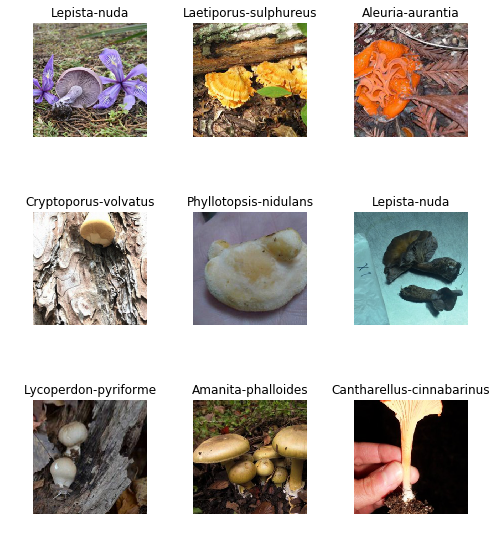

In [66]:
data.show_batch(rows=3, figsize=(7,8))

In [67]:
len(data.train_ds), len(data.valid_ds)

(32892, 8222)

### Training the Model

Using Resnet34:

In [68]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [69]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,2.482826,1.778454,0.462661,07:26
1,1.878352,1.400698,0.376794,07:25
2,1.550997,1.213976,0.327657,07:23
3,1.359692,1.159657,0.315738,07:23


In [70]:
learn.save('stage-1')

In [71]:
learn.unfreeze()

In [72]:
learn.lr_find()

epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


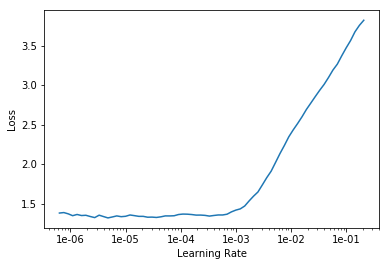

In [73]:
learn.recorder.plot()

In [74]:
learn.fit_one_cycle(2, max_lr=slice(3e-6, 3e-4))

epoch,train_loss,valid_loss,error_rate,time
0,1.234584,1.032709,0.280710,10:15
1,1.073168,0.963856,0.263926,10:13


In [75]:
learn.save('stage-2')

In [76]:
learn.load('stage-2');

In [77]:
interp = ClassificationInterpretation.from_learner(learn)

In [78]:
losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

Now we can see which species were most frequently mistaken:

In [79]:
interp.most_confused(min_val=2)

[('Psilocybe-ovoideocystidiata', 'Psilocybe-cyanescens', 21),
 ('Pleurotus-ostreatus', 'Pleurotus-pulmonarius', 20),
 ('Psilocybe-cyanescens', 'Psilocybe-ovoideocystidiata', 16),
 ('Lenzites-betulina', 'Trametes-versicolor', 13),
 ('Fomitopsis-pinicola', 'Fomitopsis-mounceae', 11),
 ('Ganoderma-tsugae', 'Ganoderma-oregonense', 11),
 ('Pleurotus-pulmonarius', 'Pleurotus-ostreatus', 10),
 ('Stereum-ostrea', 'Trametes-versicolor', 10),
 ('Fomitopsis-mounceae', 'Ganoderma-applanatum', 9),
 ('Armillaria-mellea', 'Armillaria-tabescens', 8),
 ('Galerina-autumnalis', 'Psilocybe-cyanescens', 8),
 ('Hypholoma-capnoides', 'Hypholoma-fasciculare', 8),
 ('Trametes-versicolor', 'Trichaptum-biforme', 8),
 ('Trichaptum-biforme', 'Lenzites-betulina', 8),
 ('Trichaptum-biforme', 'Trametes-versicolor', 8),
 ('Coprinellus-micaceus', 'Psilocybe-ovoideocystidiata', 7),
 ('Galerina-autumnalis', 'Psilocybe-ovoideocystidiata', 7),
 ('Pluteus-cervinus', 'Megacollybia-rodmani', 7),
 ('Psilocybe-ovoideocystidiata

Now this is where it would help to be a mushroom expert in order to know which of these mistakes can be grouped without really impairing the usefullness of the classifier.

I do know for example that the psilocybe species look quite similar, have similar edibility properties and can therefore be grouped without too much harm. Similarly for the amanita species I know that they are mostly poisonous, and foragers are discouraged from even trying to attempt to identity whether an amanita is poisonous or edible, so these can also be grouped. 

### Removing Junk Images


First I am going to remove images that are not actually of mushrooms from the dataset. These might be microscopy images, or extremely close up such that features can not be determined, or very far away (e.g. photo of a tree with a mushroom on it), or people holding mushrooms.

I DO NOT expect this to dramatically improve the accuracy of the model, as I am quite confident that the noisy images are distributed randomly throughout the dataset. However once removed, I can train any subsequent iterations on this new cleaned dataset, so it is worth doing imo.  

In [8]:
from fastai.widgets import *

In [9]:
db = (ImageList.from_folder(mushroom_images)
                   .split_none()
                   .label_from_folder()
                   .transform(get_transforms(), size=320)
                   .databunch()
     )

In [10]:
learn_cln = cnn_learner(db, models.resnet34, metrics=error_rate)

learn_cln.load('stage-2');

In [11]:
ds, idxs = DatasetFormatter().from_toplosses(learn_cln)

In [12]:
ImageCleaner(ds, idxs, mushroom_images)

Button(button_style='primary', description='Next Batch', layout=Layout(width='auto'), style=ButtonStyle())

Now we can recreate the databunch with the cleaned images:

In [20]:
np.random.seed(42)

db_clean = ImageDataBunch.from_csv(mushroom_images, folder=".", valid_pct=0.2, csv_labels='cleaned.csv',
ds_tfms=get_transforms(), size=320, num_workers=4).normalize(imagenet_stats)

In [21]:
learn_cln = cnn_learner(db_clean, models.resnet34, metrics=error_rate)

In [22]:
learn_cln.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,2.500551,1.773913,0.467668,03:57
1,1.891172,1.369233,0.370119,03:58
2,1.543231,1.181639,0.318266,03:57
3,1.351879,1.128324,0.308659,03:59


In [23]:
learn_cln.save('c-r34-224-c2+-4e')

In [24]:
learn_cln.unfreeze()

In [25]:
learn_cln.lr_find()

epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


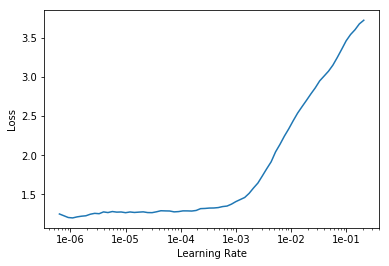

In [26]:
learn_cln.recorder.plot()

In [27]:
learn_cln.fit_one_cycle(4, max_lr=slice(3e-6, 3e-4))

epoch,train_loss,valid_loss,error_rate,time
0,1.263712,1.049358,0.287474,04:11
1,1.106399,0.923671,0.252371,04:14
2,0.915156,0.854681,0.235004,04:12
3,0.809052,0.843200,0.226998,04:13


In [28]:
learn_cln.save('c-r34-224-c2+-8e')

In [29]:
learn_cln.unfreeze()

In [30]:
learn_cln.lr_find()

epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


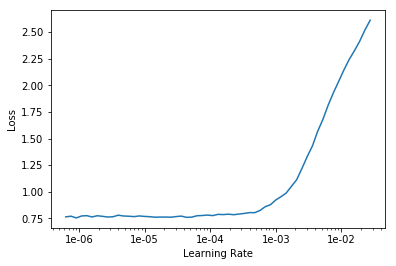

In [31]:
learn_cln.recorder.plot()

In [32]:
learn_cln.fit_one_cycle(4, max_lr=slice(3e-6, 3e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.828399,0.847176,0.232171,04:11
1,0.761146,0.797441,0.220963,04:18
2,0.624900,0.758802,0.208893,04:13
3,0.553258,0.747895,0.205567,04:14


In [33]:
learn_cln.save('c-r34-320-c2.5+-12e')

### So a model based on observations of confidence 2.5 or greater results in the same accuracy as a model based on observations of confidence 2 or higher - See mush-obs-filtering-100tax notebook